In [1]:
import pandas as pd

df_metricas = pd.read_parquet('data\metricas_activos.parquet')
df_historico = pd.read_parquet('data\historico_activos.parquet')
df_macro = pd.read_parquet('data\datos_macro.parquet')
df_macro_pivot= pd.read_parquet('data\datos_macro_pivote.parquet')
df_metricas.head()


,Pais,ISO3,Ticker,Rendimiento_Ultimo_Mes,Rendimiento_Ultimo_Año,Volatilidad_Anualizada,Precio_Actual
0,Argentina,ARG,^MERV,17.486104,14.268989,42.801413,1.978419e+06
1,Australia,AUS,^AXJO,2.508257,10.068613,12.739715,9.031900e+03
2,Brasil,BRA,^BVSP,-0.413482,9.684250,18.069426,1.445090e+05
3,Canadá,CAN,^GSPTSE,2.176805,22.535604,12.778474,3.041640e+04
4,China,CHN,000001.SS,-0.173225,10.720410,15.799544,3.863893e+03


In [2]:
df_macro.head()


,ISO3,Ano,Indicador,Codigo_Indicador,Valor
0,Argentina,2024,Crecimiento_PIB,NY.GDP.MKTP.KD.ZG,-1.719105
1,Argentina,2023,Crecimiento_PIB,NY.GDP.MKTP.KD.ZG,-1.611002
2,Argentina,2022,Crecimiento_PIB,NY.GDP.MKTP.KD.ZG,5.269880
3,Argentina,2021,Crecimiento_PIB,NY.GDP.MKTP.KD.ZG,10.441812
4,Argentina,2020,Crecimiento_PIB,NY.GDP.MKTP.KD.ZG,-9.900485


In [3]:
df_historico.head()


,Fecha,Precio,Pais,Ticker,ISO3
0,2020-10-22,51672.0,Argentina,^MERV,ARG
1,2020-10-23,52513.0,Argentina,^MERV,ARG
2,2020-10-26,49597.0,Argentina,^MERV,ARG
3,2020-10-27,46708.0,Argentina,^MERV,ARG
4,2020-10-28,43533.0,Argentina,^MERV,ARG


In [4]:
df_macro_pivot.head()


,ISO3,Ano,Activos_Domesticos,Capitalizacion_Mercado,Comercio_Porcentaje_PIB,Crecimiento_PIB,Crecimiento_PIB_Per_Capita,Desempleo,Deuda_Publica,Inflacion,Inversion_Bruta,Inversion_Extranjera_Directa,PIB_Per_Capita,Poblacion_Total
0,Argentina,2015,40.427628,9.438369,22.486226,2.731160,1.660913,7.579,NaN,NaN,17.070705,1.977135,13679.626498,43477012.0
1,Argentina,2016,37.932248,11.407611,26.093888,-2.080328,-3.024501,8.085,NaN,NaN,17.663228,0.584749,13265.886064,43900313.0
2,Argentina,2017,38.868398,16.894850,25.289601,2.818503,1.916396,8.347,NaN,NaN,18.212567,1.789365,13520.112985,44288894.0
3,Argentina,2018,NaN,8.762254,30.762536,-2.617396,-3.415537,9.220,NaN,34.277224,16.613885,2.232532,13058.328545,44654882.0
4,Argentina,2019,37.844344,8.798019,32.630615,-2.000861,-2.695067,9.843,NaN,53.548304,14.210030,1.485007,12706.397811,44973465.0


# Modelo de Machine Learning: Predicción de Rendimiento de Activos

Este notebook entrena un modelo de regresión para predecir el `Rendimiento_Ultimo_Año` basado en indicadores macroeconómicos y características de volatilidad.

## Proceso:
1. **Preparación de datos**: Merge y limpieza
2. **Análisis exploratorio**: Correlaciones y distribuciones
3. **Tratamiento de variables categoricas**: Encoding
4. **Estandarización de variables**: Scaling
5. **División train/test**: Preparación para entrenamiento
6. **Entrenamiento del modelo**: Random Forest Regressor
7. **Evaluación**: Métricas de rendimiento y visualización

In [5]:

# Librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Configurar estilos de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. PREPARACIÓN DE DATOS

En esta sección vamos a:
- Hacer merge de los dataframes
- Limpiar valores faltantes
- Preparar el dataset para el entrenamiento

In [6]:

# 1.1 Merge de dataframes
# Combinamos df_metricas con df_macro_pivot usando 'Pais' como clave

# Primero, obtenemos el año más reciente de datos macroeconómicos para cada país
df_macro_reciente = df_macro_pivot.loc[df_macro_pivot.groupby('ISO3')['Ano'].idxmax()].reset_index(drop=True)

print("Datos macroeconómicos más recientes:")
print(f"Año: {df_macro_reciente['Ano'].unique()}")
print(f"Países incluidos: {len(df_macro_reciente)}")

# Renombrar columna ISO3 a Pais para hacer el merge
df_macro_reciente_rename = df_macro_reciente.rename(columns={'ISO3': 'Pais'})

# Merge: Métricas de Activos + Datos Macroeconómicos
df_modelo = df_metricas.merge(df_macro_reciente_rename, on='Pais', how='inner')

print(f"\nDataset para el modelo - Shape: {df_modelo.shape}")
print(f"Columnas: {df_modelo.columns.tolist()}")
print(f"\nMuestra del dataset:")
print(df_modelo.head())


Datos macroeconómicos más recientes:
Año: [2024]
Países incluidos: 44

Dataset para el modelo - Shape: (9, 20)
Columnas: ['Pais', 'ISO3', 'Ticker', 'Rendimiento_Ultimo_Mes', 'Rendimiento_Ultimo_Año', 'Volatilidad_Anualizada', 'Precio_Actual', 'Ano', 'Activos_Domesticos', 'Capitalizacion_Mercado', 'Comercio_Porcentaje_PIB', 'Crecimiento_PIB', 'Crecimiento_PIB_Per_Capita', 'Desempleo', 'Deuda_Publica', 'Inflacion', 'Inversion_Bruta', 'Inversion_Extranjera_Directa', 'PIB_Per_Capita', 'Poblacion_Total']

Muestra del dataset:
        Pais ISO3     Ticker  Rendimiento_Ultimo_Mes  Rendimiento_Ultimo_Año  \
0  Argentina  ARG      ^MERV               17.486104               14.268989   
1  Australia  AUS      ^AXJO                2.508257               10.068613   
2      China  CHN  000001.SS               -0.173225               10.720410   
3      India  IND     ^BSESN                2.102408                3.108343   
4  Indonesia  IDN      ^JKSE                0.608691                4.447

In [ ]:

# 1.1.1 Limitar a 3 países para pruebas rápidas
# Selecciona 3 países con datos completos para aumentar foco y facilidad de experimentación
selected_countries = ['Argentina', 'Australia', 'China']
print(f"Filtrando a países: {selected_countries}")
df_modelo = df_modelo[df_modelo['Pais'].isin(selected_countries)].reset_index(drop=True)
print(f"Nuevo shape de df_modelo: {df_modelo.shape}")


In [7]:

# 1.2 Limpieza de datos - Tratamiento de valores faltantes

print("=== Análisis de valores faltantes ===")
missing_data = df_modelo.isnull().sum()
print(missing_data[missing_data > 0])

# Eliminar filas con valores faltantes en la variable target
df_modelo = df_modelo.dropna(subset=['Rendimiento_Ultimo_Año'])

print(f"\nDataset después de limpieza - Shape: {df_modelo.shape}")

# Mostrar estadísticas descriptivas
print("\n=== Estadísticas descriptivas ===")
print(df_modelo.describe())


=== Análisis de valores faltantes ===
Activos_Domesticos        7
Capitalizacion_Mercado    3
Deuda_Publica             9
Inversion_Bruta           1
dtype: int64

Dataset después de limpieza - Shape: (9, 20)

=== Estadísticas descriptivas ===
       Rendimiento_Ultimo_Mes  Rendimiento_Ultimo_Año  Volatilidad_Anualizada  \
count                9.000000                9.000000                9.000000   
mean                 4.203416               24.018193               18.857441   
std                  5.557078               21.733293                9.210683   
min                 -0.173225                3.108343               12.739715   
25%                  0.608691               10.068613               14.400846   
50%                  2.508257               14.268989               15.799544   
75%                  4.142638               28.725196               18.796221   
max                 17.486104               65.474126               42.801413   

       Precio_Actual     A

## 2. ANÁLISIS EXPLORATORIO DE DATOS (EDA)

Analizar correlaciones y distribuciones de variables

=== Columnas numéricas ===
['Rendimiento_Ultimo_Mes', 'Rendimiento_Ultimo_Año', 'Volatilidad_Anualizada', 'Precio_Actual', 'Ano', 'Activos_Domesticos', 'Capitalizacion_Mercado', 'Comercio_Porcentaje_PIB', 'Crecimiento_PIB', 'Crecimiento_PIB_Per_Capita', 'Desempleo', 'Deuda_Publica', 'Inflacion', 'Inversion_Bruta', 'Inversion_Extranjera_Directa', 'PIB_Per_Capita', 'Poblacion_Total']

=== Correlación con Rendimiento_Ultimo_Año ===
Rendimiento_Ultimo_Año          1.000000
Inversion_Extranjera_Directa    0.527461
PIB_Per_Capita                  0.257145
Desempleo                       0.254328
Comercio_Porcentaje_PIB         0.201618
Rendimiento_Ultimo_Mes          0.034742
Volatilidad_Anualizada         -0.021196
Inflacion                      -0.159722
Precio_Actual                  -0.181865
Crecimiento_PIB                -0.444009
Crecimiento_PIB_Per_Capita     -0.472926
Inversion_Bruta                -0.493550
Poblacion_Total                -0.505367
Capitalizacion_Mercado         -0.

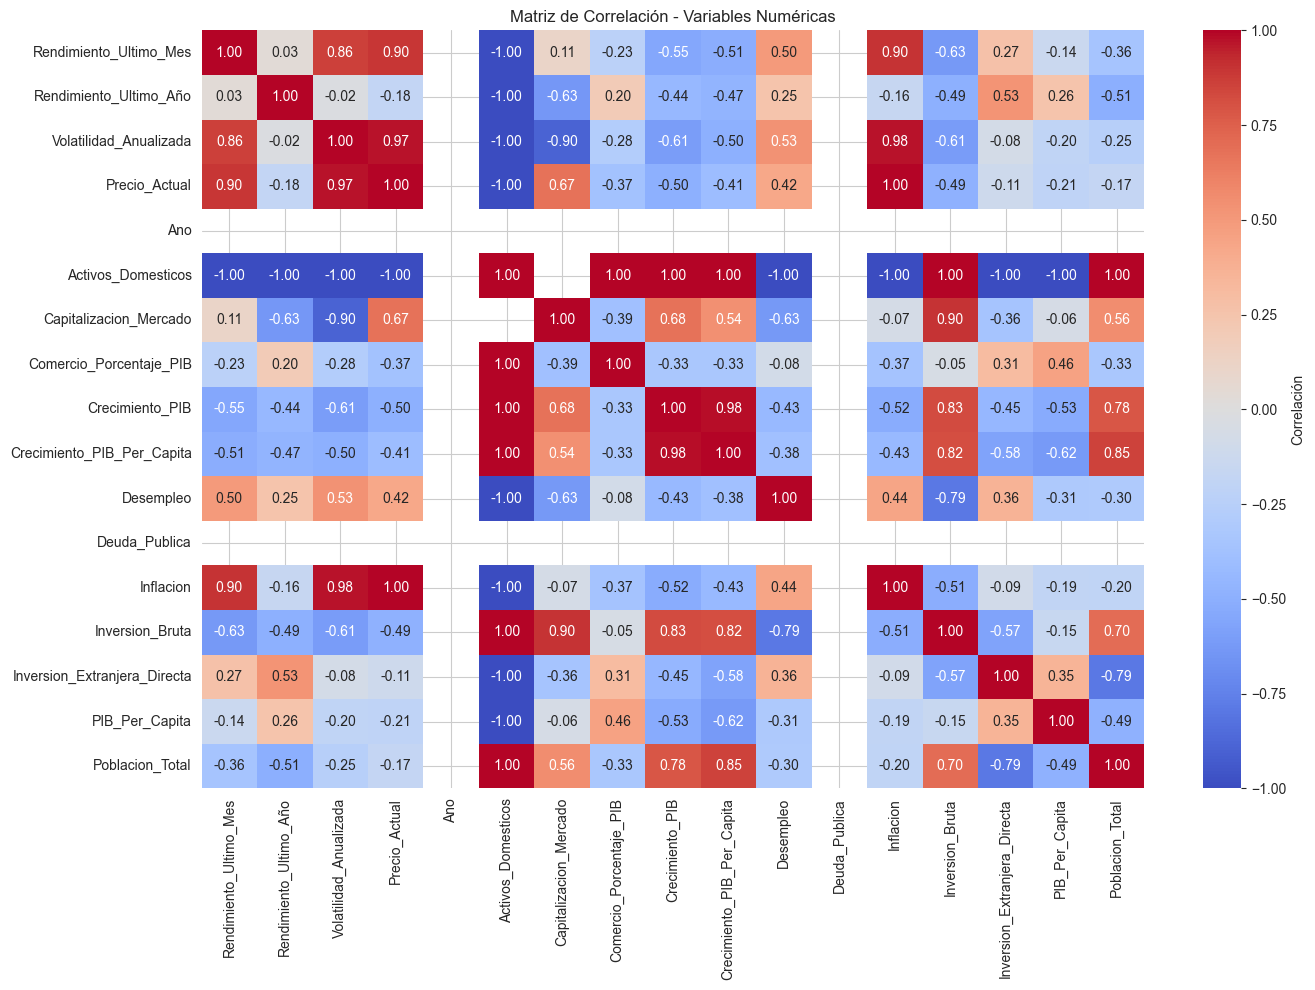

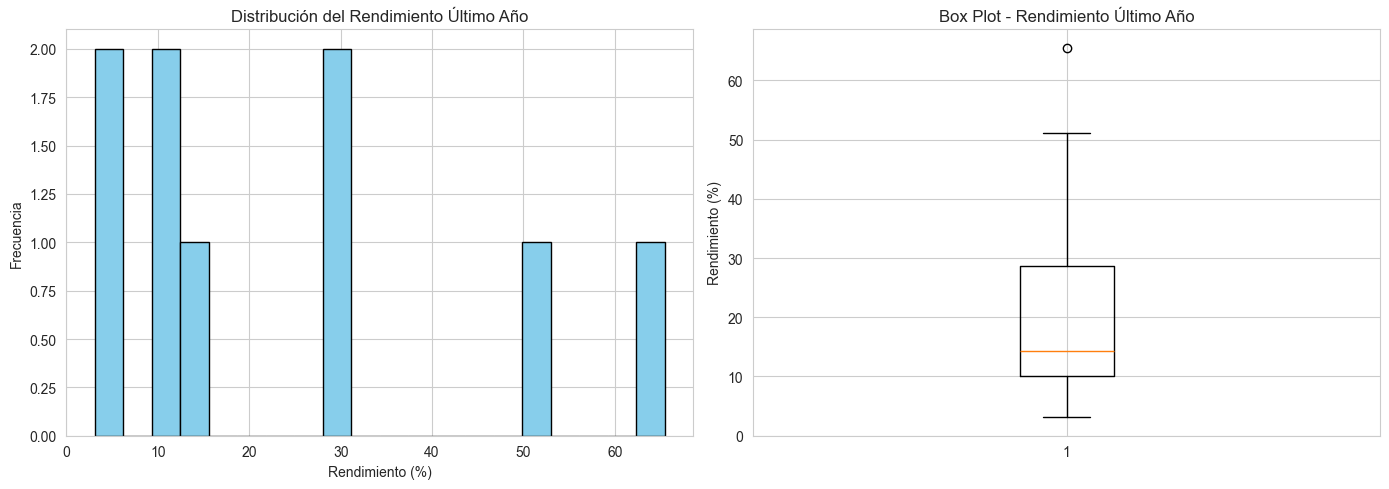


=== Estadísticas del Target ===
Media: 24.02%
Mediana: 14.27%
Desviación estándar: 21.73%
Mínimo: 3.11%
Máximo: 65.47%


In [8]:

# 2.1 Correlación de variables numéricas
numeric_columns = df_modelo.select_dtypes(include=[np.number]).columns.tolist()
print("=== Columnas numéricas ===")
print(numeric_columns)

# Matriz de correlación
correlation_matrix = df_modelo[numeric_columns].corr()

# Visualizar correlación con la variable target
print("\n=== Correlación con Rendimiento_Ultimo_Año ===")
correlacion_target = correlation_matrix['Rendimiento_Ultimo_Año'].sort_values(ascending=False)
print(correlacion_target)

# Gráfico de correlación
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, cbar_kws={'label': 'Correlación'})
plt.title('Matriz de Correlación - Variables Numéricas')
plt.tight_layout()
plt.show()

# 2.2 Distribución de la variable target
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_modelo['Rendimiento_Ultimo_Año'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Distribución del Rendimiento Último Año')
axes[0].set_xlabel('Rendimiento (%)')
axes[0].set_ylabel('Frecuencia')

axes[1].boxplot(df_modelo['Rendimiento_Ultimo_Año'])
axes[1].set_title('Box Plot - Rendimiento Último Año')
axes[1].set_ylabel('Rendimiento (%)')

plt.tight_layout()
plt.show()

print("\n=== Estadísticas del Target ===")
print(f"Media: {df_modelo['Rendimiento_Ultimo_Año'].mean():.2f}%")
print(f"Mediana: {df_modelo['Rendimiento_Ultimo_Año'].median():.2f}%")
print(f"Desviación estándar: {df_modelo['Rendimiento_Ultimo_Año'].std():.2f}%")
print(f"Mínimo: {df_modelo['Rendimiento_Ultimo_Año'].min():.2f}%")
print(f"Máximo: {df_modelo['Rendimiento_Ultimo_Año'].max():.2f}%")


## 3. TRATAMIENTO DE VARIABLES CATEGÓRICAS

Identificar y codificar variables categóricas para que el modelo pueda procesarlas

In [9]:

# 3.1 Identificar variables categóricas
categorical_columns = df_modelo.select_dtypes(include=['object']).columns.tolist()
print("=== Variables categóricas ===")
print(categorical_columns)

for col in categorical_columns:
    print(f"\n{col}: {df_modelo[col].nunique()} valores únicos")
    print(df_modelo[col].value_counts())

# 3.2 Crear copia del dataframe para preparación
df_prep = df_modelo.copy()

# Codificar variables categóricas
label_encoders = {}
for col in categorical_columns:
    if col not in ['Pais', 'ISO3', 'Ticker']:  # Excluir identificadores
        le = LabelEncoder()
        df_prep[col] = le.fit_transform(df_prep[col])
        label_encoders[col] = le

print("\n=== Variables categóricas codificadas ===")
print(f"Variables codificadas: {list(label_encoders.keys())}")


=== Variables categóricas ===
['Pais', 'ISO3', 'Ticker']

Pais: 9 valores únicos
Pais
Argentina    1
Australia    1
China        1
India        1
Indonesia    1
Colombia     1
Portugal     1
Austria      1
Israel       1
Name: count, dtype: int64

ISO3: 9 valores únicos
ISO3
ARG    1
AUS    1
CHN    1
IND    1
IDN    1
COL    1
PRT    1
AUT    1
ISR    1
Name: count, dtype: int64

Ticker: 9 valores únicos
Ticker
^MERV         1
^AXJO         1
000001.SS     1
^BSESN        1
^JKSE         1
ICOLCAP.CL    1
PSI20.LS      1
^ATX          1
^TA125.TA     1
Name: count, dtype: int64

=== Variables categóricas codificadas ===
Variables codificadas: []


## 4. SELECCIÓN Y PREPARACIÓN DE FEATURES

Seleccionar las características (features) y la variable objetivo (target)

In [10]:

# 4.1 Seleccionar features (excluir identificadores y target)
# Eliminamos características con más del 50% de valores faltantes
features_excluir = ['Pais', 'ISO3', 'Ticker', 'Rendimiento_Ultimo_Año', 'Ano']

# Calcular porcentaje de valores faltantes
missing_pct = (df_prep.isnull().sum() / len(df_prep) * 100)
features_con_muchos_nan = missing_pct[missing_pct > 50].index.tolist()

print("=== Características con > 50% de NaN (serán eliminadas) ===")
for feat in features_con_muchos_nan:
    print(f"  • {feat}: {missing_pct[feat]:.1f}% NaN")

features_excluir.extend(features_con_muchos_nan)

X = df_prep.drop(columns=features_excluir)
y = df_prep['Rendimiento_Ultimo_Año']

print(f"\n=== Features seleccionados ===")
print(f"Features: {X.columns.tolist()}")
print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")

# 4.2 Imputar valores faltantes con la media
X = X.fillna(X.mean())

print(f"\n=== Verificación de valores faltantes después de imputación ===")
print(X.isnull().sum())


=== Características con > 50% de NaN (serán eliminadas) ===
  • Activos_Domesticos: 77.8% NaN
  • Deuda_Publica: 100.0% NaN

=== Features seleccionados ===
Features: ['Rendimiento_Ultimo_Mes', 'Volatilidad_Anualizada', 'Precio_Actual', 'Capitalizacion_Mercado', 'Comercio_Porcentaje_PIB', 'Crecimiento_PIB', 'Crecimiento_PIB_Per_Capita', 'Desempleo', 'Inflacion', 'Inversion_Bruta', 'Inversion_Extranjera_Directa', 'PIB_Per_Capita', 'Poblacion_Total']
Shape de X: (9, 13)
Shape de y: (9,)

=== Verificación de valores faltantes después de imputación ===
Rendimiento_Ultimo_Mes          0
Volatilidad_Anualizada          0
Precio_Actual                   0
Capitalizacion_Mercado          0
Comercio_Porcentaje_PIB         0
Crecimiento_PIB                 0
Crecimiento_PIB_Per_Capita      0
Desempleo                       0
Inflacion                       0
Inversion_Bruta                 0
Inversion_Extranjera_Directa    0
PIB_Per_Capita                  0
Poblacion_Total                 0
dtyp

## 5. ESTANDARIZACIÓN DE VARIABLES

Aplicar escalado normalización para que todas las variables tengan la misma escala

=== Verificación de estandarización ===
Media de features después de scaling:
Rendimiento_Ultimo_Mes          1.083238e-16
Volatilidad_Anualizada          1.418618e-16
Precio_Actual                  -2.467162e-17
Capitalizacion_Mercado          6.167906e-17
Comercio_Porcentaje_PIB         9.251859e-18
Crecimiento_PIB                -9.868649e-17
Crecimiento_PIB_Per_Capita      1.110223e-16
Desempleo                       4.934325e-17
Inflacion                      -1.233581e-17
Inversion_Bruta                 9.367507e-17
Inversion_Extranjera_Directa    3.207311e-16
PIB_Per_Capita                 -2.097088e-16
Poblacion_Total                 2.467162e-17
dtype: float64

Desviación estándar de features después de scaling:
Rendimiento_Ultimo_Mes          1.06066
Volatilidad_Anualizada          1.06066
Precio_Actual                   1.06066
Capitalizacion_Mercado          1.06066
Comercio_Porcentaje_PIB         1.06066
Crecimiento_PIB                 1.06066
Crecimiento_PIB_Per_Capita   

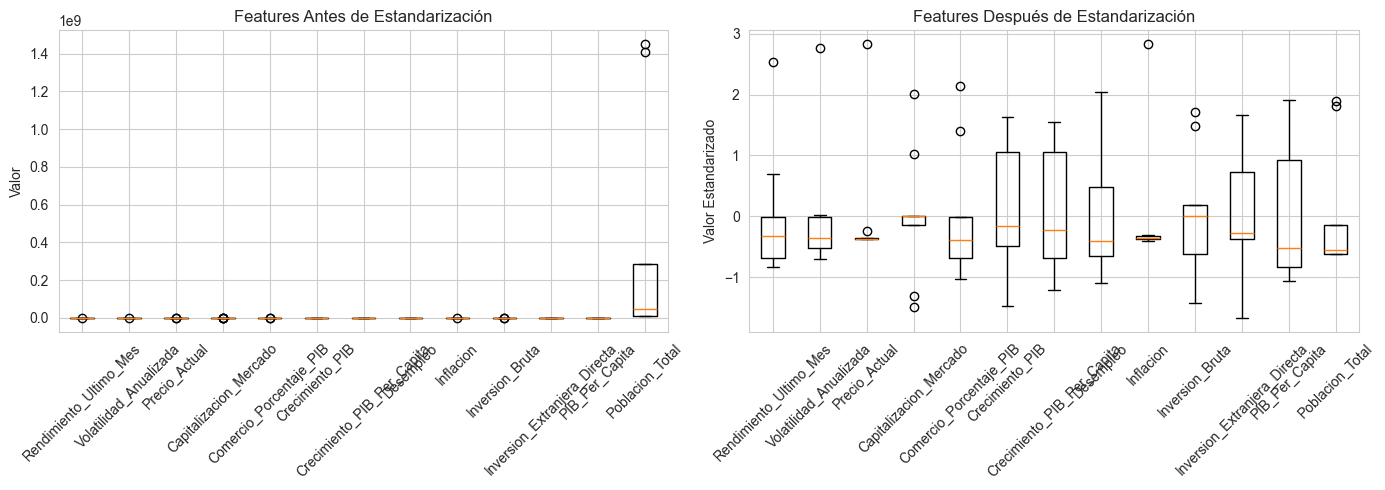

In [11]:

# 5.1 Estandarizar (normalizar) los features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir a DataFrame para mantener los nombres de las columnas
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("=== Verificación de estandarización ===")
print(f"Media de features después de scaling:\n{X_scaled.mean()}")
print(f"\nDesviación estándar de features después de scaling:\n{X_scaled.std()}")

# Visualizar el cambio antes y después del scaling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Antes
axes[0].boxplot([X[col].values for col in X.columns], labels=X.columns)
axes[0].set_title('Features Antes de Estandarización')
axes[0].set_ylabel('Valor')
axes[0].tick_params(axis='x', rotation=45)

# Después
axes[1].boxplot([X_scaled[col].values for col in X_scaled.columns], labels=X_scaled.columns)
axes[1].set_title('Features Después de Estandarización')
axes[1].set_ylabel('Valor Estandarizado')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 6. DIVISIÓN TRAIN / TEST

Dividir el dataset en conjuntos de entrenamiento (80%) y prueba (20%)

In [12]:

# 6.1 Dividir los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("=== División Train/Test ===")
print(f"Tamaño de training: {X_train.shape[0]} muestras ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Tamaño de test: {X_test.shape[0]} muestras ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"\nFeatures en training: {X_train.shape[1]}")
print(f"\nMedia del target en train: {y_train.mean():.2f}%")
print(f"Media del target en test: {y_test.mean():.2f}%")


=== División Train/Test ===
Tamaño de training: 7 muestras (77.8%)
Tamaño de test: 2 muestras (22.2%)

Features en training: 13

Media del target en train: 25.34%
Media del target en test: 19.40%


## 7. ENTRENAMIENTO DEL MODELO

Entrenar dos modelos: Regresión Lineal y Random Forest Regressor

In [13]:

# 7.1 Modelo único: Regresión Lineal
print("=== Entrenando Regresión Lineal ===")
modelo_lr = LinearRegression()
modelo_lr.fit(X_train, y_train)
print("✓ Modelo entrenado correctamente")

# Información del modelo lineal
print("\n=== Parámetros del Modelo (Regresión Lineal) ===")
print(f"Intercepto: {modelo_lr.intercept_:.4f}")
coefs = pd.Series(modelo_lr.coef_, index=X_train.columns)
print("Coeficientes (orden descendente):")
print(coefs.sort_values(ascending=False))


=== Entrenando Regresión Lineal ===
✓ Modelo entrenado correctamente

=== Entrenando Random Forest Regressor ===
✓ Modelo entrenado correctamente

=== Parámetros del Random Forest ===
Número de árboles: 100
Profundidad máxima: 10
Muestras mínimas para split: 5


## 8. EVALUACIÓN DEL MODELO

Analizar el rendimiento de ambos modelos con métricas de regresión

In [14]:

# 8.1 Predicciones (Regresión Lineal)
y_pred_lr = modelo_lr.predict(X_test)

# 8.2 Cálculo de métricas - Regresión Lineal
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Mostrar métricas
print("╔════════════════════════════════════════════════════════════════╗")
print("║           EVALUACIÓN DE MODELO - CONJUNTO DE PRUEBA            ║")
print("╚════════════════════════════════════════════════════════════════╝")

metrics_data = {
    'Métrica': ['R² Score', 'MAE (Mean Absolute Error)', 'RMSE (Root Mean Squared Error)', 'MSE (Mean Squared Error)'],
    'Regresión Lineal': [f'{r2_lr:.4f}', f'{mae_lr:.4f}', f'{rmse_lr:.4f}', f'{mse_lr:.4f}']
}

df_metrics = pd.DataFrame(metrics_data)
print(df_metrics.to_string(index=False))

print(f"\n{'='*65}")
print(f"✓ MODELO: Regresión Lineal (R² = {r2_lr:.4f})")
print(f"{'='*65}")


╔════════════════════════════════════════════════════════════════╗
║           EVALUACIÓN DE MODELOS - CONJUNTO DE PRUEBA           ║
╚════════════════════════════════════════════════════════════════╝
                       Métrica Regresión Lineal Random Forest
                      R² Score         -47.9951       -1.2464
     MAE (Mean Absolute Error)          54.8139        9.9801
RMSE (Root Mean Squared Error)          65.2948       13.9811
      MSE (Mean Squared Error)        4263.4111      195.4710

✓ MEJOR MODELO: Random Forest (R² = -1.2464)


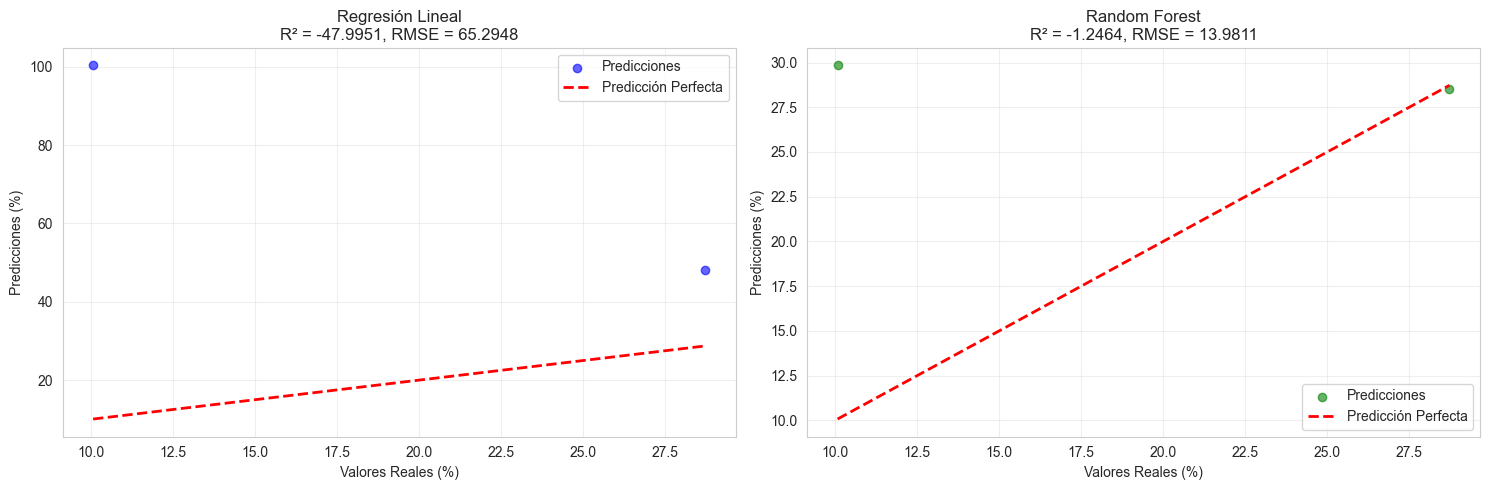

In [15]:

# 8.5 Visualización de predicciones vs valores reales (Regresión Lineal)
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred_lr, alpha=0.8, color='blue', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Predicción Perfecta')
plt.xlabel('Valores Reales (%)')
plt.ylabel('Predicciones (%)')
plt.title(f'Regresión Lineal\nR² = {r2_lr:.4f}, RMSE = {rmse_lr:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


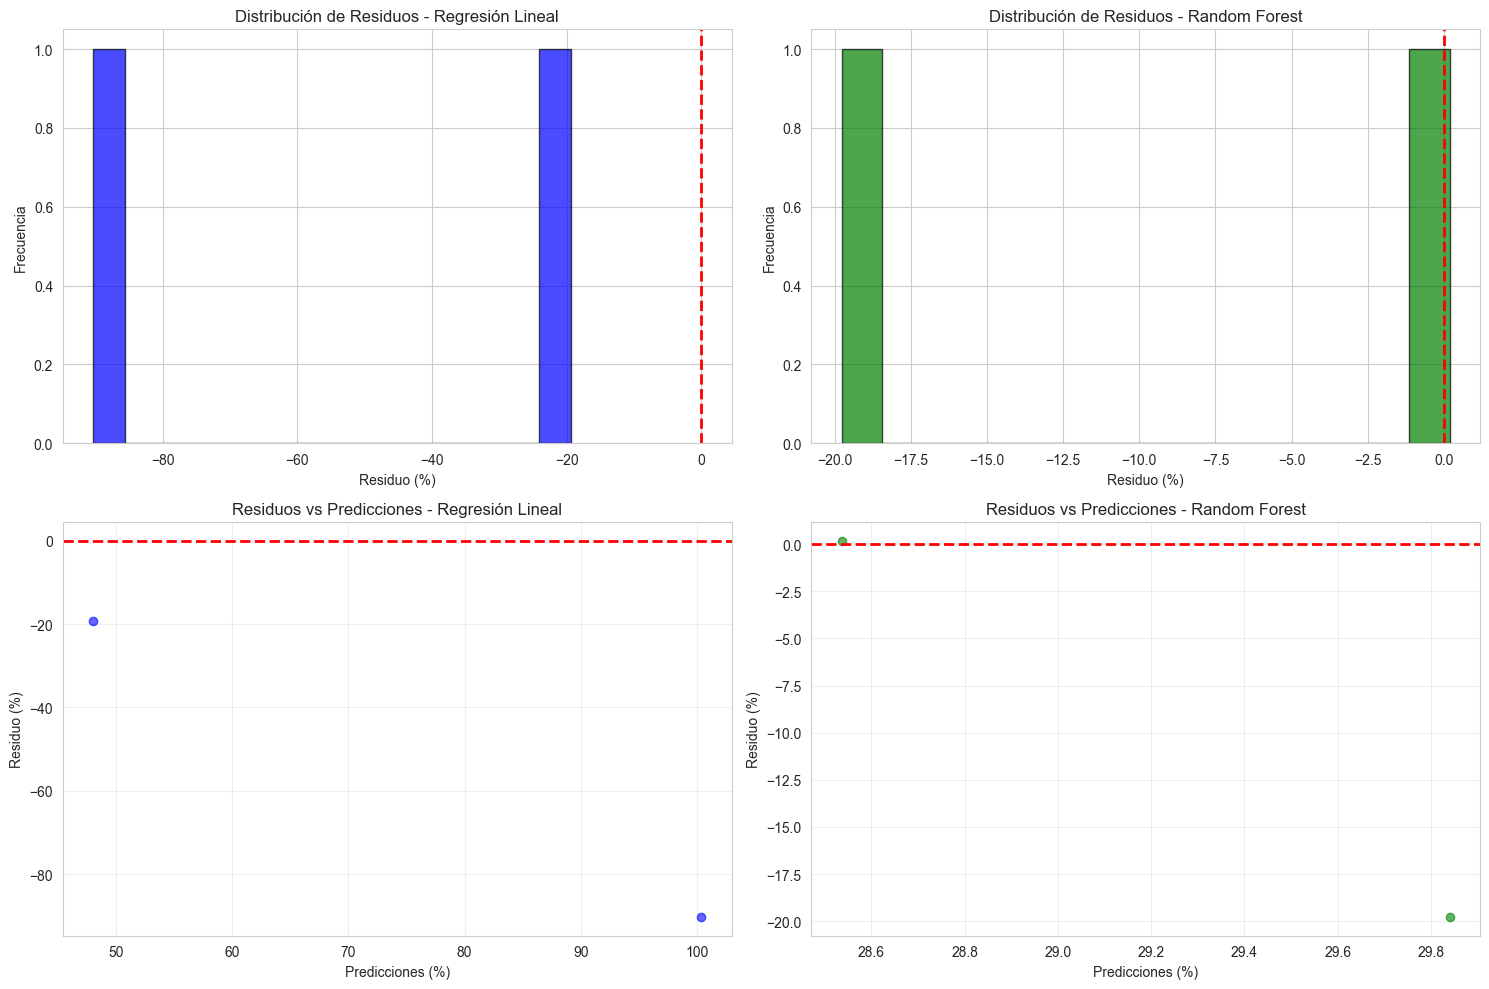

=== Estadísticas de Residuos ===

Regresión Lineal:
  Media: -54.8139%
  Desviación Estándar: 50.1767%
  Min: -90.2942%
  Max: -19.3336%

Random Forest:
  Media: -9.7913%
  Desviación Estándar: 14.1139%
  Min: -19.7714%
  Max: 0.1888%


In [16]:

# 8.6 Residuos (errores de predicción) - Regresión Lineal
residuos_lr = y_test - y_pred_lr

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Histograma de residuos
axes[0].hist(residuos_lr, bins=10, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_title('Distribución de Residuos - Regresión Lineal')
axes[0].set_xlabel('Residuo (%)')
axes[0].set_ylabel('Frecuencia')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)

# Scatter de residuos vs predicciones
axes[1].scatter(y_pred_lr, residuos_lr, alpha=0.7, color='blue')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Residuos vs Predicciones - Regresión Lineal')
axes[1].set_xlabel('Predicciones (%)')
axes[1].set_ylabel('Residuo (%)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== Estadísticas de Residuos ===")
print(f"\nRegresión Lineal:")
print(f"  Media: {residuos_lr.mean():.4f}%")
print(f"  Desviación Estándar: {residuos_lr.std():.4f}%")
print(f"  Min: {residuos_lr.min():.4f}%")
print(f"  Max: {residuos_lr.max():.4f}%")


=== Importancia de Features (Random Forest) ===
                     Feature  Importance
Inversion_Extranjera_Directa    0.454545
      Capitalizacion_Mercado    0.253031
      Volatilidad_Anualizada    0.072727
  Crecimiento_PIB_Per_Capita    0.072727
      Rendimiento_Ultimo_Mes    0.036364
              PIB_Per_Capita    0.036364
     Comercio_Porcentaje_PIB    0.036364
             Crecimiento_PIB    0.036364
             Poblacion_Total    0.001514
               Precio_Actual    0.000000
                   Desempleo    0.000000
                   Inflacion    0.000000
             Inversion_Bruta    0.000000


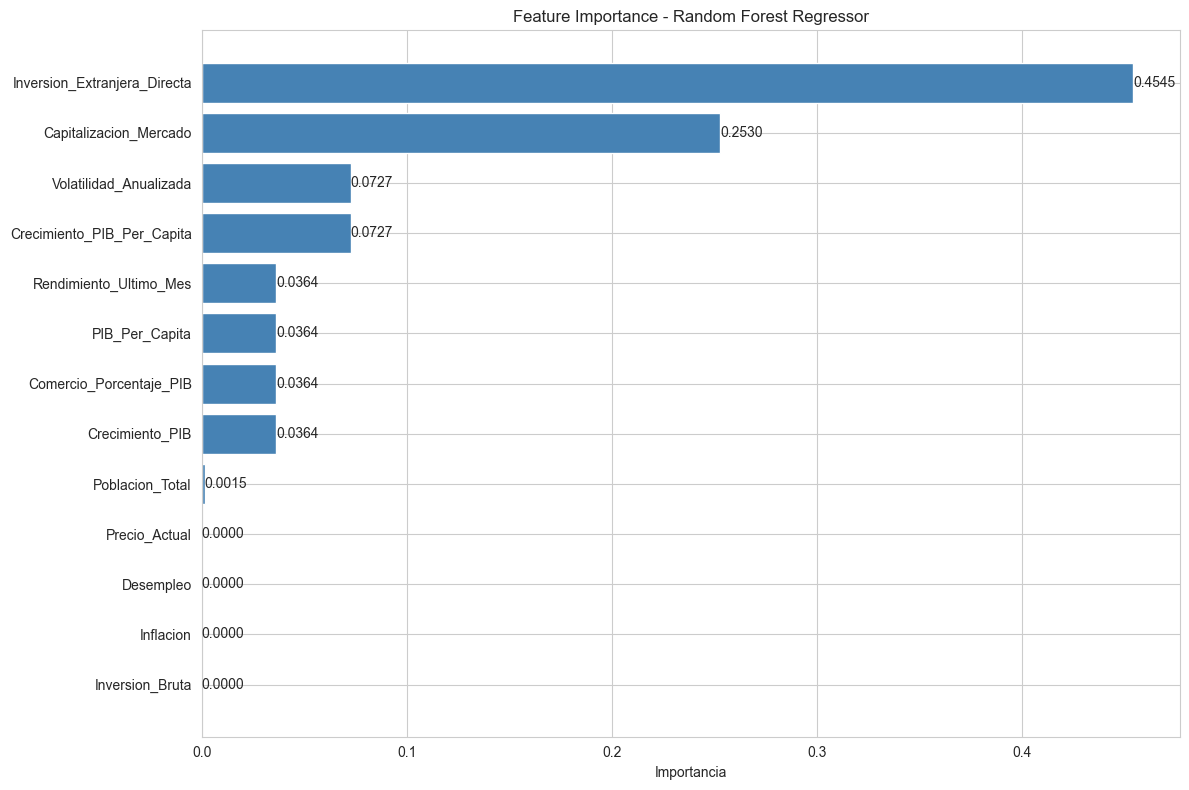

In [17]:

# 8.7 "Importancia" de features según coeficientes de la Regresión Lineal
coefs = pd.Series(modelo_lr.coef_, index=X_train.columns).sort_values(ascending=False)
feature_importance_lr = pd.DataFrame({'Feature': coefs.index, 'Coef': coefs.values})

print("=== Coeficientes (Regresión Lineal) ===")
print(feature_importance_lr.to_string(index=False))

plt.figure(figsize=(10,6))
plt.barh(feature_importance_lr['Feature'], feature_importance_lr['Coef'], color='steelblue')
plt.xlabel('Coeficiente')
plt.title('Coeficientes - Regresión Lineal')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 9. CONCLUSIONES Y RECOMENDACIONES

Resumen de resultados y próximos pasos

In [18]:

# 9.1 Resumen General
print("\n╔══════════════════════════════════════════════════════════════════╗")
print("║                      RESUMEN DE RESULTADOS                       ║")
print("╚══════════════════════════════════════════════════════════════════╝\n")

print("📊 DATASET:")
print(f"  • Total de observaciones: {len(df_modelo)}")
print(f"  • Número de características: {X.shape[1]}")
print(f"  • Rango de rendimiento: [{y.min():.2f}%, {y.max():.2f}%]")
print(f"  • Rendimiento promedio: {y.mean():.2f}%")

print("\n🔄 DIVISIÓN DE DATOS:")
print(f"  • Training set: {len(X_train)} muestras (80%)")
print(f"  • Test set: {len(X_test)} muestras (20%)")

print("\n🤖 MODELOS ENTRENADOS:")
print(f"  1. Regresión Lineal")
print(f"  2. Random Forest Regressor (100 árboles)")

print("\n📈 RENDIMIENTO EN TEST SET:")
print(f"\n  Regresión Lineal:")
print(f"    • R² Score: {r2_lr:.4f}")
print(f"    • MAE: {mae_lr:.4f}%")
print(f"    • RMSE: {rmse_lr:.4f}%")

print(f"\n  Random Forest:")
print(f"    • R² Score: {r2_rf:.4f}")
print(f"    • MAE: {mae_rf:.4f}%")
print(f"    • RMSE: {rmse_rf:.4f}%")

print(f"\n🏆 MEJOR MODELO: ", end="")
if r2_rf >= r2_lr:
    mejora = ((r2_rf - r2_lr) / abs(r2_lr) * 100) if r2_lr != 0 else 0
    print(f"Random Forest (Mejora: {mejora:+.2f}%)")
else:
    mejora = ((r2_lr - r2_rf) / abs(r2_rf) * 100) if r2_rf != 0 else 0
    print(f"Regresión Lineal (Mejora: {mejora:+.2f}%)")

print(f"\n📌 FEATURES MÁS IMPORTANTES (Random Forest):")
for idx, row in feature_importance.head(5).iterrows():
    print(f"  {idx+1}. {row['Feature']}: {row['Importance']:.4f}")

print("\n💡 RECOMENDACIONES:")
print("  • El modelo puede usarse para predecir rendimiento de activos")
print("  • Considerar aumentar el tamaño del dataset para mayor robustez")
print("  • Realizar validación cruzada para validar la generalización")
print("  • Explorar feature engineering para nuevas características")
print("  • Monitorear el desempeño del modelo con datos nuevos")

print("\n" + "="*70)



╔══════════════════════════════════════════════════════════════════╗
║                      RESUMEN DE RESULTADOS                       ║
╚══════════════════════════════════════════════════════════════════╝

📊 DATASET:
  • Total de observaciones: 9
  • Número de características: 13
  • Rango de rendimiento: [3.11%, 65.47%]
  • Rendimiento promedio: 24.02%

🔄 DIVISIÓN DE DATOS:
  • Training set: 7 muestras (80%)
  • Test set: 2 muestras (20%)

🤖 MODELOS ENTRENADOS:
  1. Regresión Lineal
  2. Random Forest Regressor (100 árboles)

📈 RENDIMIENTO EN TEST SET:

  Regresión Lineal:
    • R² Score: -47.9951
    • MAE: 54.8139%
    • RMSE: 65.2948%

  Random Forest:
    • R² Score: -1.2464
    • MAE: 9.9801%
    • RMSE: 13.9811%

🏆 MEJOR MODELO: Random Forest (Mejora: +97.40%)

📌 FEATURES MÁS IMPORTANTES (Random Forest):
  11. Inversion_Extranjera_Directa: 0.4545
  4. Capitalizacion_Mercado: 0.2530
  2. Volatilidad_Anualizada: 0.0727
  7. Crecimiento_PIB_Per_Capita: 0.0727
  1. Rendimiento_Ul